### Load Preprocessed Data
Let's first load the preprocessed data and understand its structure

In [1]:
import pandas as pd

# Let's load the preprocessed dataset
file_path = 'data/preprocessed_guardian_editorials_data.csv'
data = pd.read_csv(file_path)

# Now let's check the dataset
print("Dataset Preview:")
print(data.head())

Dataset Preview:
         date_of_publication  \
0  2024-11-30 19:30:34+00:00   
1  2024-11-30 19:00:33+00:00   
2  2024-11-30 18:00:33+00:00   
3  2024-11-30 17:00:31+00:00   
4  2024-11-30 16:00:32+00:00   

                                            headline  \
0  the observer view shaky ceasefire is no victor...   
1  the observer view ignore the stigma and tackle...   
2  wicked would be fun and forgettable but for th...   
3  feeding off anger fuelled by russia enter clin...   
4  what connects huddersfields s football stadium...   

                                             content  headline_length  \
0  for the people of lebanon last weeks agreement...               98   
1  i wanted them all to notice this is the title ...               85   
2  the war on woke has a new target and her name ...               85   
3  politics in romania can be a bloody business e...               93   
4   was a vintage year for architecture the years...               74   

   content_len

Upon evaluating the BoW representation below, I found some inconsistancies which were not addressed in the preprocessing stage. Therefore, below we are going to to sort them out and make the BoW more consistent.

In [2]:
import re

# Let's clean the 'content' column
def clean_text(text):
    # Remove non-alphabetic characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Apply the cleaning function
data['content'] = data['content'].apply(clean_text)

In [3]:
import spacy

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# Function to clean text using spaCy
def spacy_clean(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# Apply the cleaning function
data['content'] = data['content'].apply(spacy_clean)

### Bag of Words (BoW) Representation
Let's use the *CountVectorizer* to create a BoW representation of the content column and save it. Let's also evaluate the quality of the BoW matrrix by checking the sparsity.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# Let's use the 'content' column for BoW representation
corpus = data['content']

# Let's initialize the CountVectorizer
# and, Limit the features for efficiency and remove very rare or common words
custom_stop_words = ['ul', 'pthe', 'abc', 'aa', 'zoe', 'aside']  # Add identified noisy terms here
bow_vectorizer = CountVectorizer(max_features=5000, stop_words=custom_stop_words, min_df=2, max_df=0.8)

# Now let's fit and transform the content column
bow_matrix = bow_vectorizer.fit_transform(corpus)

# And, save the vocabulary
vocabulary = bow_vectorizer.get_feature_names_out()

# Now, let's check the shape of the BoW matrix
print(f"BoW Matrix Shape: {bow_matrix.shape}")

# And also, check the contents of the BoW matrix
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vocabulary)
print("\nBoW Representation Preview:")
print(bow_df.head())

BoW Matrix Shape: (4503, 5000)

BoW Representation Preview:
   abandon  abbott  abide  ability  able  abolish  aboriginal  abortion  \
0        0       0      0        0     0        0           0         0   
1        1       0      0        1     1        0           0         0   
2        0       0      0        0     0        0           0         0   
3        0       0      0        0     0        0           0         0   
4        0       0      0        1     1        0           0         0   

   aboutp  abroad  ...  york  yorkshire  young  youp  youth  youtube  zealand  \
0       0       0  ...     0          0      0     0      0        0        0   
1       0       0  ...     0          0      0     0      0        0        0   
2       0       0  ...     0          0      2     0      0        0        0   
3       0       0  ...     0          0      0     0      0        0        0   
4       0       0  ...     0          0      0     0      0        0        0   

  

In [22]:
# Now, let's save the BoW matrix
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vocabulary)
bow_df.to_csv('data/bow_representation.csv', index=False)

#### Evaluate BoW Matrix Quality
Now, let's evaluate the BoW Matrix Quality by checking the matrix sparsity, distribution of non-zero elements across rows, visualizing the sparsity pattern, checking the frequency of Top Words, and evaluating the rare words.

In [23]:
# Let's check sparsity of the BoW matrix
non_zero_elements = bow_matrix.nnz  # Number of non-zero elements
total_elements = bow_matrix.shape[0] * bow_matrix.shape[1]  # Total elements in the matrix
sparsity = (1 - (non_zero_elements / total_elements)) * 100

print(f"Sparsity of BoW matrix: {sparsity:.2f}%")

Sparsity of BoW matrix: 94.94%


In [24]:
import numpy as np

# Let's count non-zero elements per row (document)
non_zero_per_row = np.diff(bow_matrix.indptr)

print(f"Non-zero elements per row (documents):")
print(f"Min: {non_zero_per_row.min()}, Max: {non_zero_per_row.max()}, Mean: {non_zero_per_row.mean():.2f}")

Non-zero elements per row (documents):
Min: 67, Max: 919, Mean: 253.06


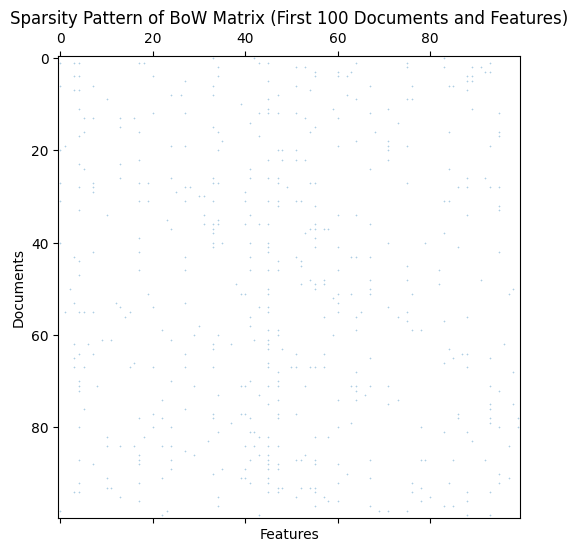

In [25]:
import matplotlib.pyplot as plt

# Let's also visualize a subset of the BoW matrix
plt.figure(figsize=(10, 6))
plt.spy(bow_matrix[:100, :100], markersize=0.1)
plt.title("Sparsity Pattern of BoW Matrix (First 100 Documents and Features)")
plt.xlabel("Features")
plt.ylabel("Documents")
plt.show()


Top 10 Frequent Words in the Corpus:
            word  frequency
2923         not      13180
3160      people      10521
4980        year       8871
2536        like       8303
1897  government       6974
4535        time       6962
2893         new       6265
3115       party       5898
2439      labour       5891
4634       trump       5831


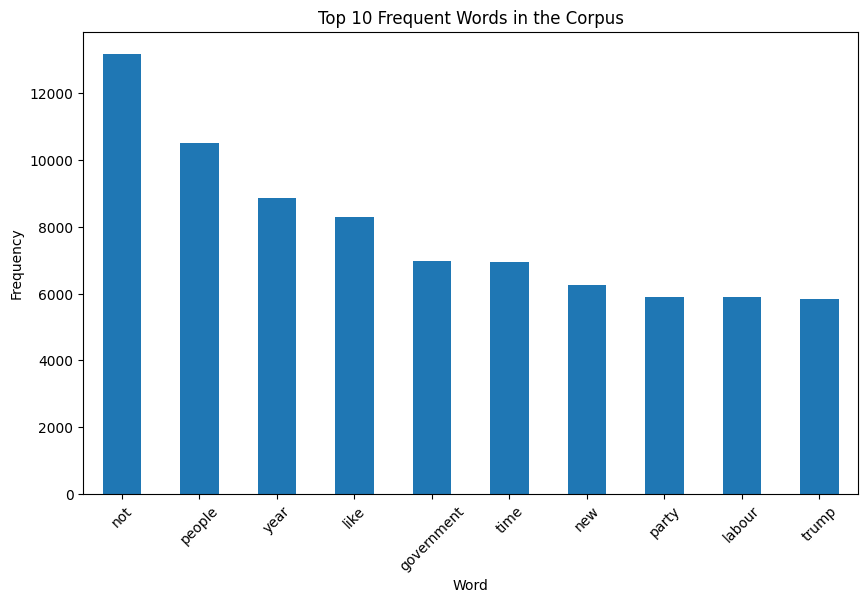

In [26]:
# Let's calculate the word frequencies
word_counts = bow_matrix.sum(axis=0).A1  # Sum across rows
word_freq = pd.DataFrame({'word': vocabulary, 'frequency': word_counts})
word_freq = word_freq.sort_values(by='frequency', ascending=False).head(10)

# And display top words
print("\nTop 10 Frequent Words in the Corpus:")
print(word_freq)

# And also visualize word frequencies
word_freq.plot(kind='bar', x='word', y='frequency', legend=False, figsize=(10, 6))
plt.title("Top 10 Frequent Words in the Corpus")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [27]:
# Words appearing in very few documents
rare_words = (bow_matrix.sum(axis=0) == 1).sum()  # Words appearing in only one document
print(f"Number of rare words (appearing in only one document): {rare_words}")

Number of rare words (appearing in only one document): 0


### Latent Dirichlet Allocation (LDA)
Now let's perform LDA for topic modeling using the BoW matrix and save the document topic and term topic matrices. Let's also extract the top words for each topic to interpret results.

In [28]:
from sklearn.decomposition import LatentDirichletAllocation

# Let's initialize the LDA model
num_topics = 15
lda = LatentDirichletAllocation(n_components=num_topics, random_state=123)

# Now let's fit the LDA model to the BoW matrix
document_topic_matrix = lda.fit_transform(bow_matrix)

# Now, let's save the document-topic and term-topic matrices
document_topic_df = pd.DataFrame(document_topic_matrix, 
                                 columns=[f'topic_{i}' for i in range(num_topics)])
document_topic_df.to_csv('data/document_topic_matrix.csv', index=False)
print("Document-topic matrix saved to /mnt/data/document_topic_matrix.csv")

term_topic_matrix = lda.components_.T
term_topic_df = pd.DataFrame(term_topic_matrix, columns=[f'topic_{i}' for i in range(num_topics)], index=vocabulary)
term_topic_df.to_csv('data/term_topic_matrix.csv', index=True)
print("Term-topic matrix saved to data/term_topic_matrix.csv")

Document-topic matrix saved to /mnt/data/document_topic_matrix.csv
Term-topic matrix saved to data/term_topic_matrix.csv


In [29]:
# Now, let's get the top words per topic
def top_words_per_topic(term_topic_df, n_top_words=10):
    top_words = {}
    for topic in term_topic_df.columns:
        top_words[topic] = term_topic_df[topic].nlargest(n_top_words).index.tolist()
    return top_words

# Now, let's check the top words for each topic
top_words = top_words_per_topic(term_topic_df, n_top_words=10)
for topic, words in top_words.items():
    print(f"\nTop words for {topic}:")
    print(", ".join(words))


Top words for topic_0:
child, people, school, health, year, need, government, care, work, service

Top words for topic_1:
government, year, new, climate, need, people, work, cost, company, worker

Top words for topic_2:
party, labour, government, tory, conservative, minister, election, starmer, political, sunak

Top words for topic_3:
medium, like, not, year, world, people, new, news, social, public

Top words for topic_4:
trump, president, trumps, say, court, musk, republican, new, vance, donald

Top words for topic_5:
labour, tax, tory, public, cut, starmer, government, reeve, growth, budget

Top words for topic_6:
court, abortion, state, ban, law, right, supreme, woman, bill, justice

Top words for topic_7:
israel, war, gaza, israeli, netanyahu, biden, international, iran, military, attack

Top words for topic_8:
not, like, time, feel, people, know, think, thing, life, go

Top words for topic_9:
woman, people, man, violence, police, right, black, issue, sexual, like

Top words for 

#### Evaluation of LDA Results
Let's evaluate the perplexity for different numbers of topics to identify the optimal number and plot the perplexity scores.

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:34<00:00, 68.52s/it]


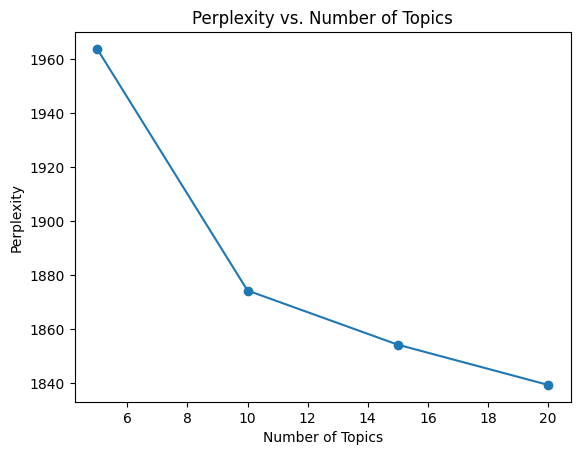

In [14]:
from tqdm import tqdm

# Let's evaluate the perplexity for a range of topics
topic_range = range(5, 21, 5)
perplexities = []
for n_topics in tqdm(topic_range):
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_model.fit(bow_matrix)
    perplexities.append(lda_model.perplexity(bow_matrix))

# And plot perplexity
plt.plot(topic_range, perplexities, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("Perplexity vs. Number of Topics")
plt.show()

### Visualizations
Now in this section, we will generate word clouds for each topic and also plot topic distribution acrross documents.

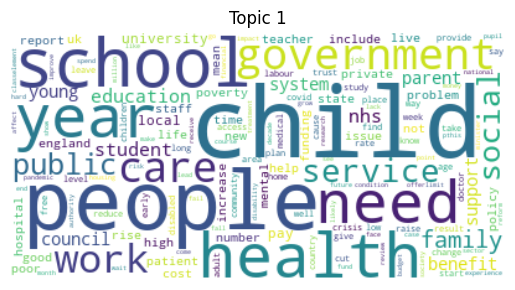

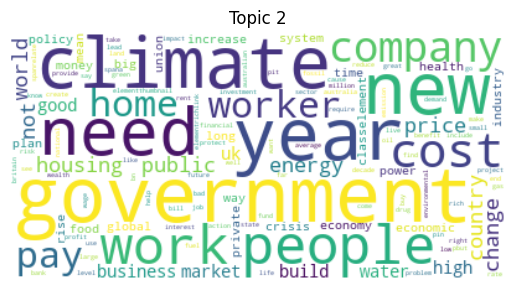

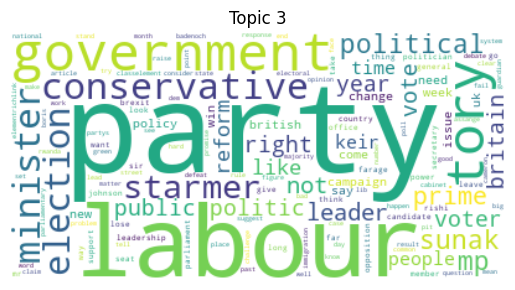

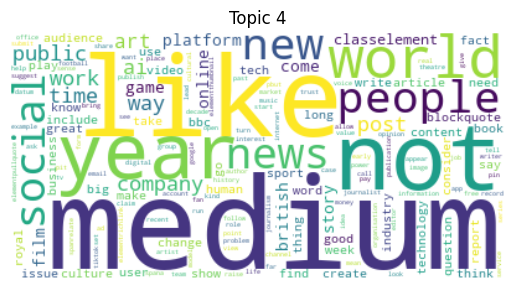

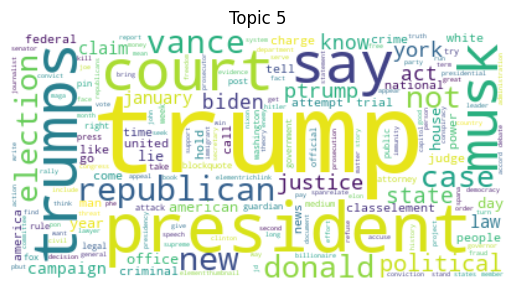

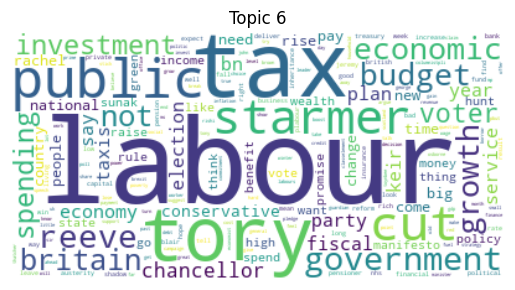

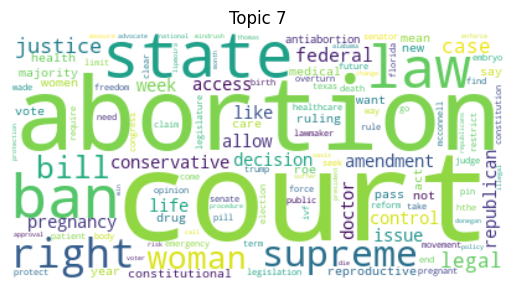

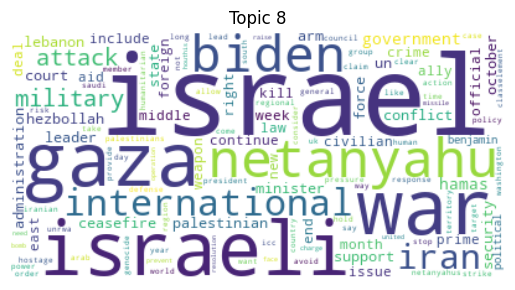

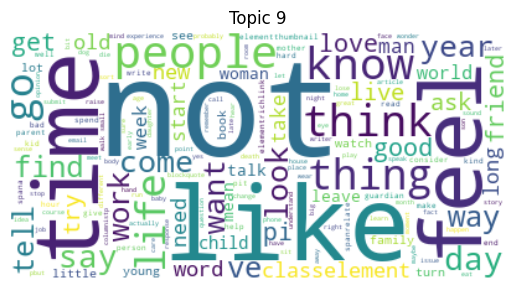

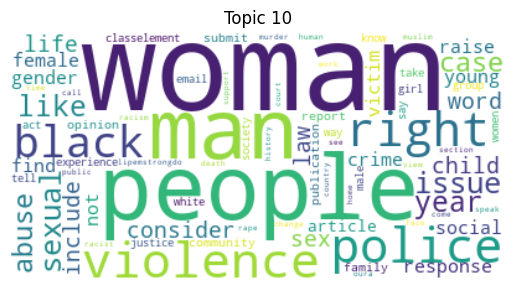

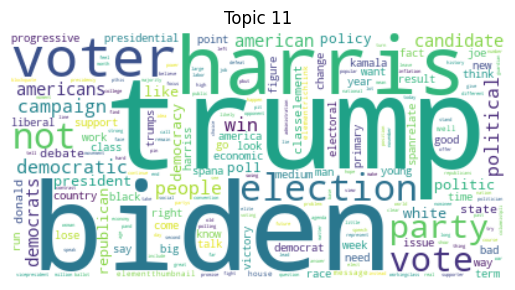

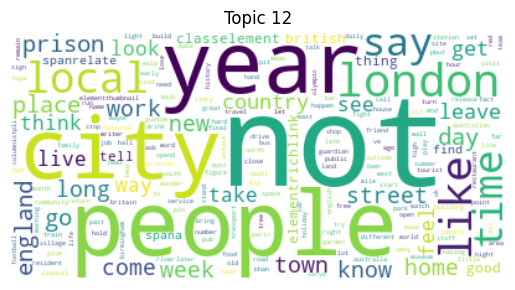

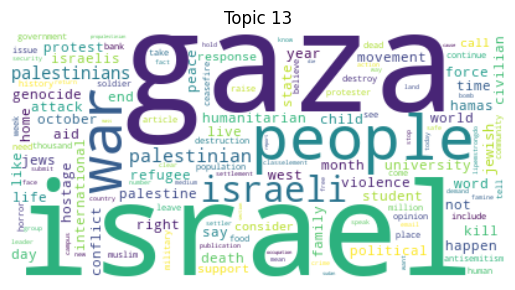

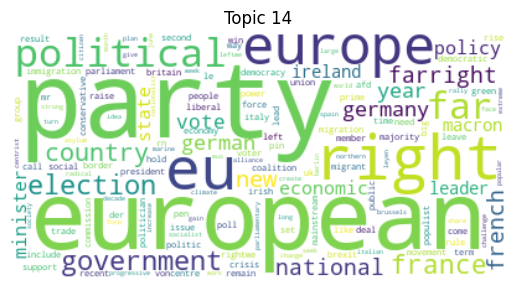

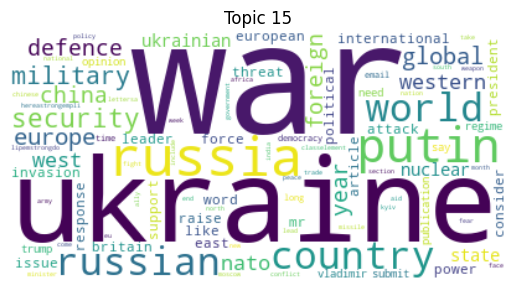

In [30]:
from wordcloud import WordCloud

# Now, let's generate the word clouds
for topic_idx, topic in enumerate(lda.components_):
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(dict(zip(vocabulary, topic)))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_idx + 1}")
    plt.show()

C:\Users\adity\AppData\Local\Temp\ipykernel_12376\2001056257.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['year_month'] = pd.to_datetime(data['date_of_publication']).dt.to_period('M')


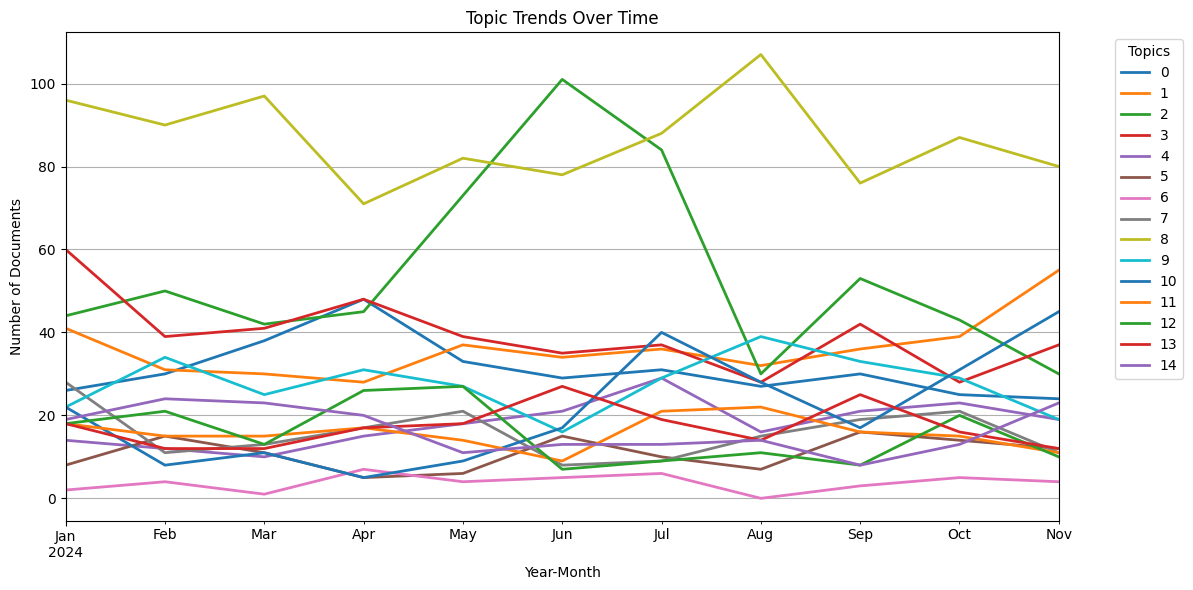

In [31]:
# Now let's visulaize the temporal trends
# Let's first add the dominant topic to the dataset
data['dominant_topic'] = document_topic_matrix.argmax(axis=1)

# And also add publication month
data['year_month'] = pd.to_datetime(data['date_of_publication']).dt.to_period('M')

# Now let's count documents per topic per month
topic_trends = data.groupby(['year_month', 'dominant_topic']).size().unstack(fill_value=0)

# And plot the trends
topic_trends.plot(figsize=(12, 6), linewidth=2)
plt.title('Topic Trends Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Documents')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig("topic_trends_over_time.png", dpi=300)
plt.show()

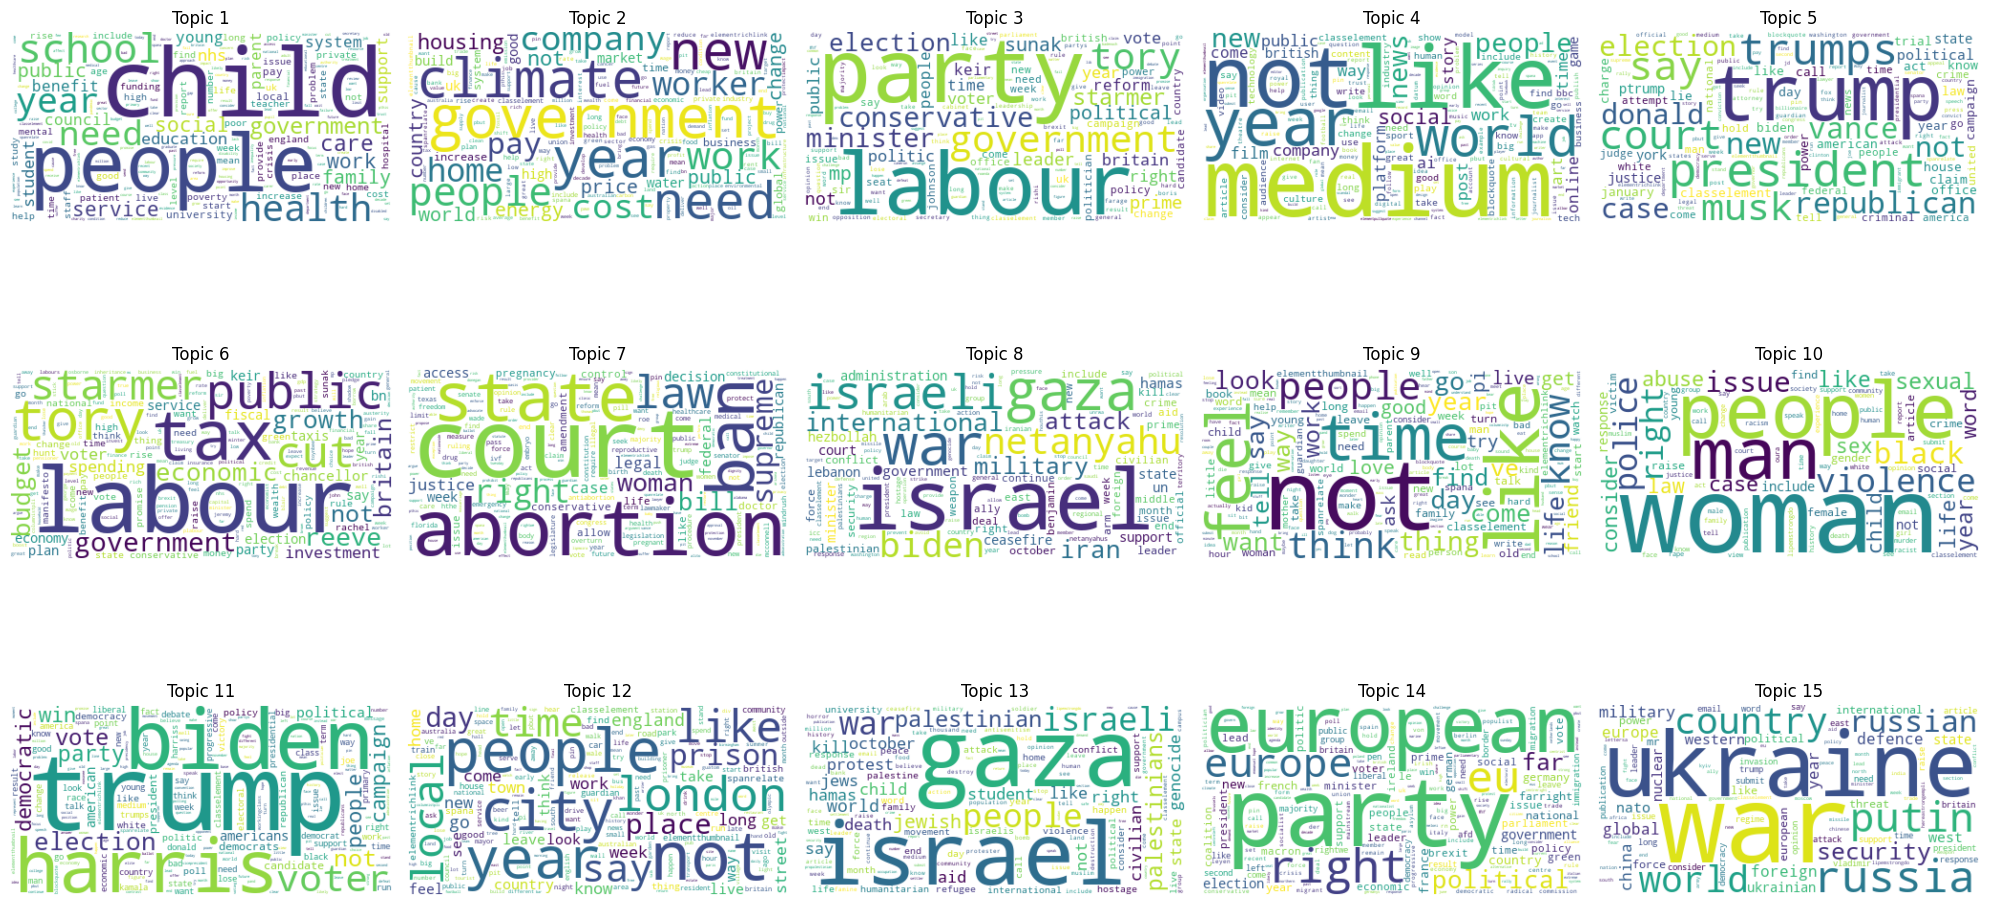

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Number of topics (from LDA)
num_topics = len(lda.components_)  # Adjust based on your LDA or clustering results

# Create a grid layout for word clouds
ncols = 5  # Number of columns in the grid
nrows = (num_topics // ncols) + (num_topics % ncols > 0)  # Calculate rows dynamically

# Initialize the figure
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))
# fig.suptitle("Word Clouds for All Topics - LDA", fontsize=24)

# Generate and plot word clouds for each topic
for topic_idx, topic in enumerate(lda.components_):
    row, col = divmod(topic_idx, ncols)  # Determine position in grid
    ax = axes[row, col]  # Get the corresponding axis
    
    # Generate the word cloud for this topic
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(
        dict(zip(vocabulary, topic))
    )
    
    # Plot the word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"Topic {topic_idx + 1}", fontsize=12)

# Remove empty axes if topics < nrows * ncols
if num_topics < nrows * ncols:
    for idx in range(num_topics, nrows * ncols):
        fig.delaxes(axes.flatten()[idx])

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
plt.savefig("word_clouds_all_topics_lda.png", dpi=300)  # Save as a single image
plt.show()